In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation (make more data available for training) and normalization for training phase
# Normalize for validation

dataTransforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.255])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#print(dataTransforms)

# Where is our data
dataDir = 'data/hymenoptera_data'

# Load the data into Datasets
imageDatasets = {x: datasets.ImageFolder(os.path.join(dataDir,x),dataTransforms[x])
                 for x in ['train','val']}
#print(imageDatasets)

# Create Loaders for easier munipulation and feeding to the Networks
dataloaders = {x: torch.utils.data.DataLoader(imageDatasets[x],batch_size=4,
                                              shuffle=True,num_workers=4)
               for x in ['train','val']}

# Size of our datasets
datasetSizes = {x: len(imageDatasets[x])
                for x in ['train', 'val']}

# Output classes we want to train for
classNames = imageDatasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


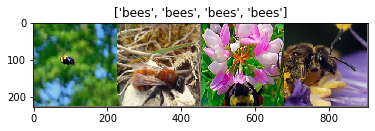

In [3]:
# Helper function to display images
def imshow(inp, title=None):
    # Convert tensor to numpy array and put channels dir last
    inp = inp.numpy().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out,title=[classNames[x] for x in classes])
    

In [4]:
def train_model(model,criterion, optimizer, scheduler, numEpochs=25):
    since = time.time()
    
    bestModelWTS = copy.deepcopy(model.state_dict())
    bestAcc = 0.0
    
    for epoch in range(numEpochs):
        print('Epoch {}/{}'.format(epoch,numEpochs - 1))
        print('='*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            
            # Iterate over our Data
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out the parameters gradients
                optimizer.zero_grad()
                
                # Forward the data
                # Track history if in traing phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    # Backward and optimize only if in traing mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Some useful Statistics
                running_loss  += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_correct.double() / datasetSizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > bestAcc:
                bestAcc= epoch_acc
                bestModelWTS = copy.deepcopy(model.state_dict())

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(bestAcc))

    # load best model weights
    model.load_state_dict(bestModelWTS)
    return model

In [5]:
# Define a helper function to visualize some predictions
def visualize_model(model, numImages=6):
    was_training = model.training
    model.eval()
    imagesSoFar = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                imagesSoFar += 1
                ax = plt.subplot(numImages//2, 2, imagesSoFar)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classNames[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if(imagesSoFar == numImages):
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# Load a pretrained model and reset the finaly fully connect layer
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/xenofon/.cache/torch/checkpoints/resnet34-333f7ec4.pth
28.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

74.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [7]:
model_ft = train_model(model_ft,criterion,optimizer,exp_lr_scheduler, numEpochs=25)

Epoch 0/24
train Loss: 0.5345 Acc: 0.7049
val Loss: 0.2280 Acc: 0.8889

Epoch 1/24
train Loss: 0.5128 Acc: 0.7623
val Loss: 0.1997 Acc: 0.9085

Epoch 2/24
train Loss: 0.4825 Acc: 0.7828
val Loss: 0.3155 Acc: 0.8562

Epoch 3/24
train Loss: 0.5242 Acc: 0.7787
val Loss: 0.1638 Acc: 0.9608

Epoch 4/24
train Loss: 0.7426 Acc: 0.7500
val Loss: 0.4766 Acc: 0.8366

Epoch 5/24
train Loss: 0.4629 Acc: 0.8115
val Loss: 0.6287 Acc: 0.8235

Epoch 6/24
train Loss: 0.4596 Acc: 0.7869
val Loss: 0.4178 Acc: 0.8758

Epoch 7/24
train Loss: 0.3021 Acc: 0.8730
val Loss: 0.3340 Acc: 0.8954

Epoch 8/24
train Loss: 0.4323 Acc: 0.8197
val Loss: 0.3286 Acc: 0.9020

Epoch 9/24
train Loss: 0.3533 Acc: 0.8279
val Loss: 0.2852 Acc: 0.9085

Epoch 10/24
train Loss: 0.4161 Acc: 0.8320
val Loss: 0.2670 Acc: 0.9150

Epoch 11/24
train Loss: 0.2913 Acc: 0.8689
val Loss: 0.3125 Acc: 0.8758

Epoch 12/24
train Loss: 0.2842 Acc: 0.8934
val Loss: 0.2921 Acc: 0.8954

Epoch 13/24
train Loss: 0.2831 Acc: 0.8689
val Loss: 0.2564 A

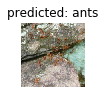

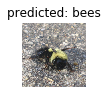

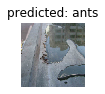

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


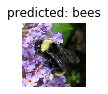

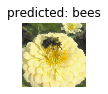

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


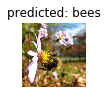

In [8]:
visualize_model(model_ft)

In [9]:
model_conv = torchvision.models.resnet50(pretrained=True)
#print(model_conv)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/xenofon/.cache/torch/checkpoints/resnet50-19c8e357.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

63.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, numEpochs=25)

Epoch 0/24
train Loss: 0.6208 Acc: 0.6475
val Loss: 0.3219 Acc: 0.8235

Epoch 1/24
train Loss: 0.5456 Acc: 0.7295
val Loss: 0.1861 Acc: 0.9216

Epoch 2/24
train Loss: 0.7298 Acc: 0.7336
val Loss: 0.1255 Acc: 0.9542

Epoch 3/24
train Loss: 0.4577 Acc: 0.8156
val Loss: 0.1379 Acc: 0.9477

Epoch 4/24
train Loss: 0.4704 Acc: 0.8238
val Loss: 0.1484 Acc: 0.9346

Epoch 5/24
train Loss: 0.3440 Acc: 0.8402
val Loss: 0.1261 Acc: 0.9608

Epoch 6/24


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()